# Classification Test

This notebook runs a single file to test the NCAN classifiers

## Import libraries

In [3]:
# Default libraries
import numpy as np
import mne
import os
import matplotlib.pyplot as plt
import scipy.signal as signal

# Import custom libraries
from functions import data_tools
from functions import processing
from functions.FeatureExtractorSSVEP import FeatureExtractorCCA as CCA
from functions.FeatureExtractorSSVEP import FeatureExtractorMSI as MSI
from functions.FeatureExtractorSSVEP import FeatureExtractorMEC as MEC

# Araz magic command
%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import and epoch data

In [17]:
# Select file to import
# file = r"C:\Users\danie\OneDrive - University of Calgary\PDF\Proyects\Datasets\easy-on-the-eyes\sub-P004\ses-S001\eeg\sub-P004_ses-S001_task-T1_run-001_eeg.xdf"
file = r"C:\Users\danie\OneDrive - University of Calgary\PDF\Proyects\Datasets\easy-on-the-eyes\sub-P005\ses-S001\eeg\sub-P005_ses-S001_task-T1_run-001_eeg.xdf"

# Import and epoch data
[eeg_time, eeg, srate] = data_tools.read_xdf(file, picks=["O1","Oz","O2"])
# [eeg_time, eeg, srate] = data_tools.read_xdf(file)
[marker_time, markers] = data_tools.read_xdf_unity_markers(file)
nchans = eeg.shape[0]

# Filter 60 Hz noise
eeg = processing.line_filter(
    eeg = eeg,
    srate = srate,
    f_notch = 60,
    f_order = 4
    )

# Epoch data
[eeg_epochs, epoch_labels] = data_tools.epochs_from_unity_markers(
    eeg_time = eeg_time,
    eeg_data = eeg,
    marker_time = marker_time,
    marker_data = markers
    )

# - Get stimuli and frequencies labels
fixed_labels = data_tools.fix_labels(epoch_labels)          # Fix labels that might be incorrect in pilot trials
dict_of_stimuli = data_tools.get_tvep_stimuli(fixed_labels) # Dictionary of unique stimulus

# Dictionary of stimulus frequencies
dict_of_freqs = {
    0: "9.090909",
    1: "14.28571",
    2: "33.33333"
    }

# - Create array of eeg epochs organized as [stimuli, freq, chans, samples]
eeg_epochs_organized = data_tools.epochs_stim_freq(
    eeg_epochs = eeg_epochs,
    labels = fixed_labels,
    stimuli = dict_of_stimuli,
    freqs = dict_of_freqs
    )

## Classification

Use different types of classifiers to test their performance

### CCA

In [18]:
type(eeg_epochs_organized.shape[-1])

int

In [19]:
subbands = np.array([[i*2, i*2+2] for i in range(1, 52)])

In [30]:
# Create classifier
cca = CCA()

# Set classifier settings
# subbands = np.array((
#     (7,11),
#     (12,16),
#     (31,35),
#     (16,20),
#     (26,30),
#     (64,68)
#     ))

cca.setup_feature_extractor(
        harmonics_count = 2,
        targets_frequencies = np.array([float(x) for x in list(dict_of_freqs.values())]),
        sampling_frequency = srate,
        samples_count = eeg_epochs_organized.shape[-1],
        filter_order = 12,
        subbands = subbands
        )

# Run classifier
nsamples = eeg_epochs_organized.shape[-1]
classifier_data = eeg_epochs_organized[2,:,:,:,:].reshape(9,nchans,nsamples)
# cca_data = signal.detrend(cca_data, type="constant")
cca_features = (cca.extract_features(classifier_data))


In [31]:
np.squeeze(cca_features).shape

(9, 51, 3)

In [32]:
# np.squeeze(cca_features)
np.max(np.squeeze(cca_features), axis=1)
# np.argmax(np.max(np.squeeze(cca_features), axis=1), axis=1)

array([[0.25771984, 0.0408557 , 0.28037181],
       [0.25771984, 0.0408557 , 0.28037181],
       [0.25771984, 0.0408557 , 0.28037181],
       [0.25771984, 0.0408557 , 0.28037181],
       [0.25771984, 0.0408557 , 0.28037181],
       [0.25771984, 0.0408557 , 0.28037181],
       [0.25771984, 0.0408557 , 0.28037181],
       [0.25771984, 0.0408557 , 0.28037181],
       [0.25771984, 0.0408557 , 0.28037181]], dtype=float32)

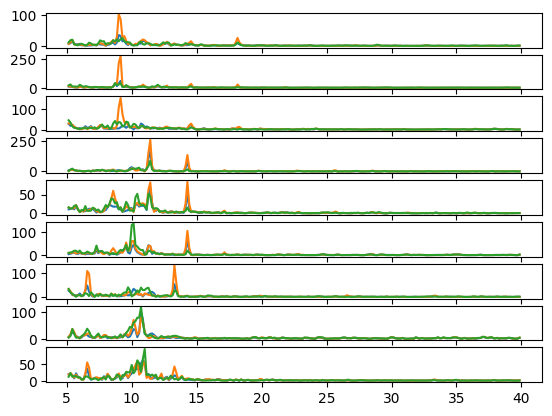

In [33]:
fig, ax = plt.subplots(9,1)


for e in range(9):
    epoch = classifier_data[e,:,:]
    [f, pxx] = signal.welch(epoch, fs = srate, nperseg = srate*7)
    mask = (f > 5) & (f < 40)
    ax[e].plot(f[mask], pxx[:,mask].T)
plt.show()

In [34]:
list(dict_of_stimuli.values())

[' Worms',
 ' Static',
 ' MaxContrast',
 ' WoodGrain',
 ' MinContrast',
 ' Voronoi',
 ' Checkerboard']

In [35]:
np.squeeze(cca_features)

array([[[0.00138292, 0.00078709, 0.00033119],
        [0.00138292, 0.00078709, 0.00033119],
        [0.00480524, 0.0014718 , 0.0002943 ],
        ...,
        [0.00026278, 0.00027306, 0.00040941],
        [0.00026278, 0.00027306, 0.00040941],
        [0.00013754, 0.00014327, 0.00022678]],

       [[0.00138292, 0.00078709, 0.00033119],
        [0.00138292, 0.00078709, 0.00033119],
        [0.00480524, 0.0014718 , 0.0002943 ],
        ...,
        [0.00026278, 0.00027306, 0.00040941],
        [0.00026278, 0.00027306, 0.00040941],
        [0.00013754, 0.00014327, 0.00022678]],

       [[0.00138292, 0.00078709, 0.00033119],
        [0.00138292, 0.00078709, 0.00033119],
        [0.00480524, 0.0014718 , 0.0002943 ],
        ...,
        [0.00026278, 0.00027306, 0.00040941],
        [0.00026278, 0.00027306, 0.00040941],
        [0.00013754, 0.00014327, 0.00022678]],

       ...,

       [[0.00138292, 0.00078709, 0.00033119],
        [0.00138292, 0.00078709, 0.00033119],
        [0.00480524, 0

### MSI

In [36]:
# Create classifier
msi = MSI()

# Set classifier settings
msi.setup_feature_extractor(
        harmonics_count = 2,
        targets_frequencies = np.array([float(x) for x in list(dict_of_freqs.values())]),
        sampling_frequency = srate,
        samples_count = eeg_epochs_organized.shape[-1],
        )

# Run classifier
# msi_data = eeg_epochs_organized[6,:,:,:,:].reshape(9,3,4114)
# msi_data = signal.detrend(msi_data)
msi_features = (msi.extract_features(classifier_data))

In [37]:
# np.squeeze(msi_features)
np.argmax(np.squeeze(msi_features), axis=1)

array([0, 0, 0, 1, 1, 1, 2, 0, 1], dtype=int64)

### MEC

In [38]:
# Create classifier
mec = MEC()

# Set classifier settings
mec.setup_feature_extractor(
        harmonics_count = 2,
        targets_frequencies = np.array([float(x) for x in list(dict_of_freqs.values())]),
        sampling_frequency = srate,
        samples_count = eeg_epochs_organized.shape[-1],
        )

# Run classifier
mec_features = (mec.extract_features(classifier_data))

In [39]:
# np.shape(mec_features)
np.squeeze(mec_features)
np.argmax(np.squeeze(mec_features), axis=1)

array([0, 0, 0, 0, 1, 1, 1, 2, 2], dtype=int64)